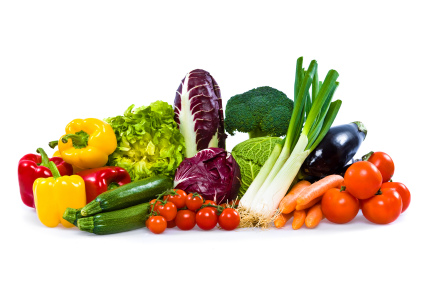

# Fruits-360 dataset: Classifying 131 fruits and veggies

In this challenge, we are required to train a model which can classify 131 fruits and vegetables.

**Data:**
* Training set size: 67692 images (one fruit or vegetable per image)
* Test set size: 22688 images (one fruit or vegetable per image)
* Multi-fruits set size: 103 images (more than one fruit (or fruit class) per image)
* Number of classes: 131 (fruits and vegetables)
* Image size: 100x100 pixels

Training and test images are in two different folders. Each of train and test image folders contains 131 fruits & vegetables in labelled sub-folders.

**This notebooks covers:**
* Understanding data
* How Deep learning architectures with pretrained weights can be used for predicting wide range of objects
* Transfer learning on ResNet50 
* Retrain ResNet50 
* Summarize results
* Show sample predictions
* Conclusion

# Import libraries

In [1]:
import numpy as np   # linear algebra
import pandas as pd   # data processing
from sklearn.datasets import load_files  # efficiently load files
import tensorflow as tf  # deep learning framework
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout
from keras.layers import Activation, Flatten
from keras.models import  Sequential
from keras import Model, optimizers
from keras.applications.vgg16 import decode_predictions
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image  # for image preprocessing
import matplotlib.pyplot as plt # for visualization
import seaborn as sns  
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from PIL import Image   # image library
import os

In [2]:
# Get some examples for visualization

img1 = "../input/dogs-cats-images/dataset/training_set/dogs/dog.100.jpg"
img2 = "../input/dogs-cats-images/dataset/test_set/cats/cat.4028.jpg"
img3 = "../input/flowers-recognition/flowers/sunflower/1008566138_6927679c8a.jpg"
img4 = "../input/fruits/fruits-360/Test/Corn/178_100.jpg"
img5 = "../input/dogs-cats-images/dataset/test_set/dogs/dog.4023.jpg"
img6 = "../input/fruits/fruits-360/Training/Apple Red Delicious/101_100.jpg"
img7 = "../input/fruits/fruits-360/Training/Blueberry/103_100.jpg"
img8 = "../input/fruits/fruits-360/Training/Banana/119_100.jpg"
img9 = "../input/fruits/fruits-360/Training/Guava/116_100.jpg"
img10 = "../input/fruits/fruits-360/Training/Papaya/102_100.jpg"
img11 = "../input/fruits/fruits-360/Training/Watermelon/101_100.jpg"
unseen_data = '../input/unseen-examples/Unseen'
imgs1 = [img1, img2, img3, img4, img5]
imgs2 = [img6, img7, img8, img9, img10, img11]
disp_fruits = ['Apple', 'Blueberry', 'Banana', 'Guava', 'Papaya', 'Watermelon']

**Display some fruits**

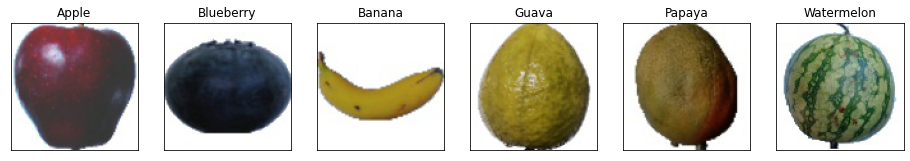

In [3]:
fig, ax = plt.subplots(1,6)
for i in range(6):
    ax[i].imshow(Image.open(imgs2[i]))
    ax[i].set_title(disp_fruits[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.set_size_inches(16,16)

# Understanding Data

Check if train and test classes are equal

In [4]:
train_path = "../input/fruits/fruits-360/Training/"
test_path = "../input/fruits/fruits-360/Test/"

# check for equality of train and test classes 
train_fv = sorted(os.listdir(train_path))
test_fv = sorted(os.listdir(test_path))
print('Train classes match Test classes:', train_fv == test_fv)

Train classes match Test classes: True


**Number of examples per class in Train and Test sets**

In [5]:
tr_count = {}
for p in train_fv:
    new_path = train_path + p 
    items = len(os.listdir(new_path))
    tr_count[p] = items
tr_data = pd.DataFrame.from_dict(tr_count, orient='index')

te_count = {}
for p in test_fv:
    new_path = test_path + p 
    items = len(os.listdir(new_path))
    te_count[p] = items
te_data = pd.DataFrame.from_dict(te_count, orient='index')

img_data = tr_data.merge(te_data, left_on=tr_data.index, right_on=te_data.index)
img_data = img_data.rename(columns={ 'key_0': 'name', '0_x':'train_imgs', '0_y': 'test_imgs'})
img_data.head()

name  train_imgs  test_imgs
0      Apple Braeburn         492        164
1  Apple Crimson Snow         444        148
2      Apple Golden 1         480        160
3      Apple Golden 2         492        164
4      Apple Golden 3         481        161

In [6]:
fig = make_subplots(rows=2, cols=1)

traces = [
    go.Bar(y=img_data.train_imgs, x=img_data.name, name = 'train'),
    go.Bar(y=img_data.test_imgs, x=img_data.name, name = 'test')
]

for i in range(2):
    fig.add_trace(traces[i], i+1, 1)

fig.update_layout(title="Train/test class distribution", height = 700)
fig.show()

**There is a near identical class distribution in train and test sets**

# Custom function to extract features from images

In [7]:
def load_image(img_path):
    """
    load image from a path and preprocess it 
    """
    img = image.load_img(img_path, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [8]:
def get_predictions(_model):
    """
    This function takes a trained model and gives top 3 predictions for a set of images
    """
    f, ax = plt.subplots(1,5)
    f.set_size_inches(100,20)
    for i in range(5):
        ax[i].imshow(Image.open(imgs1[i]).resize((200,200)))
    plt.show()
                  
    f, ax = plt.subplots(1,5)
    f.set_size_inches(100,20)
    for i,img_path in enumerate(imgs1):
        img = load_image(img_path)
        preds = decode_predictions(_model.predict(img), top=3)[0]
        b = sns.barplot(y=[c[1] for c in preds], x=[c[2] for c in preds], color='teal', ax=ax[i])
        b.tick_params(labelsize=70)
        f.tight_layout()

# Pre-trained models 

In this section, I will show how deep learning models with pretrained weights can be used for prediction in general. 
Specifically, I will be using:
* VGG-16
* ResNet50
* EfficientNetB5
The models will be applied on a variety of images including animals and flowers. 

# 1.VGG-16

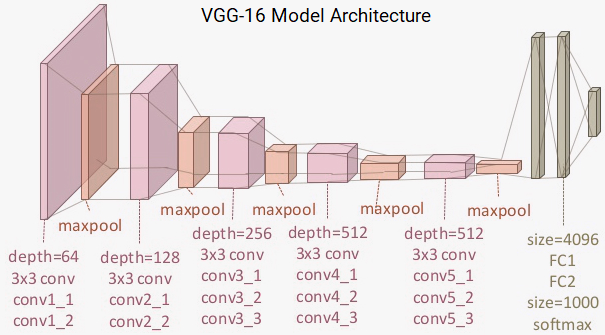

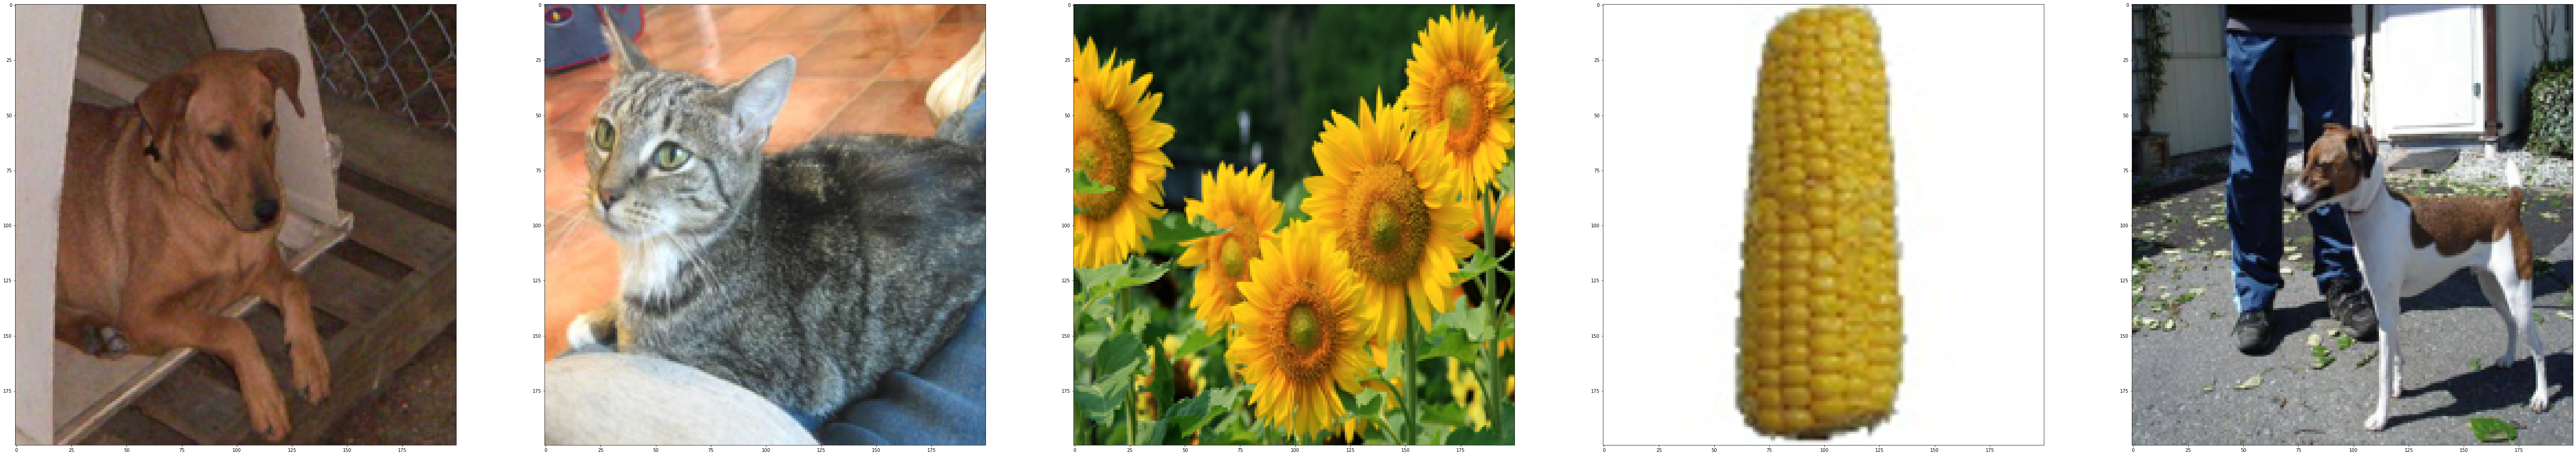

40960/35363 [==================================] - 0s 0us/step


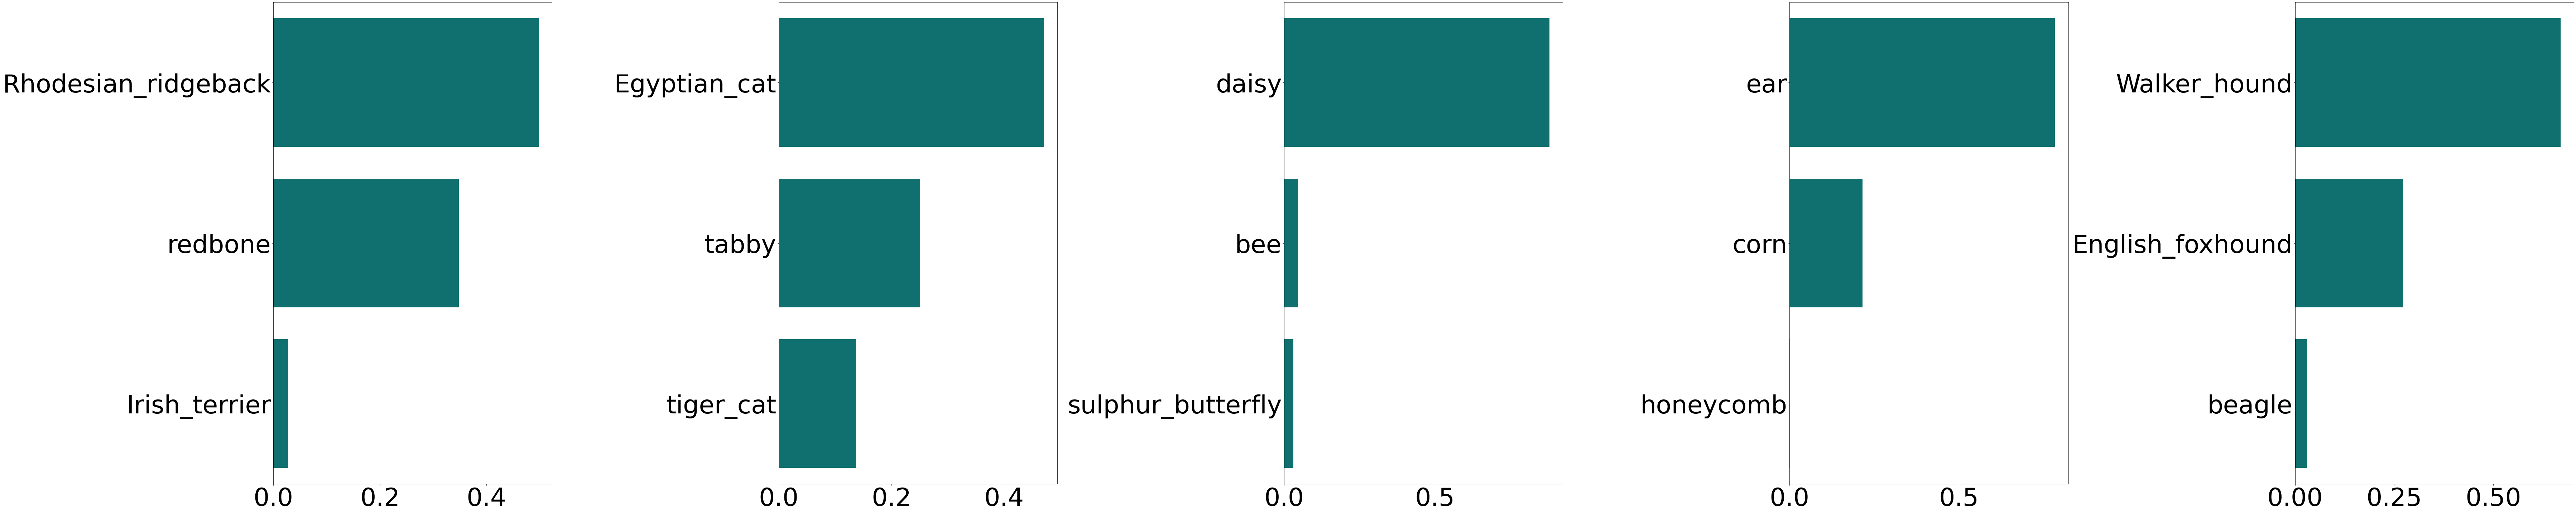

In [9]:
from keras.applications.vgg16 import VGG16
vgg16_weights = "../input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5"
vgg16_model = VGG16(weights=vgg16_weights)
get_predictions(vgg16_model)

VGG16 has done a good job with prediction. It has got the correct class in top two predictions for all five examples

# 2.ResNet50

ResNet Architecture
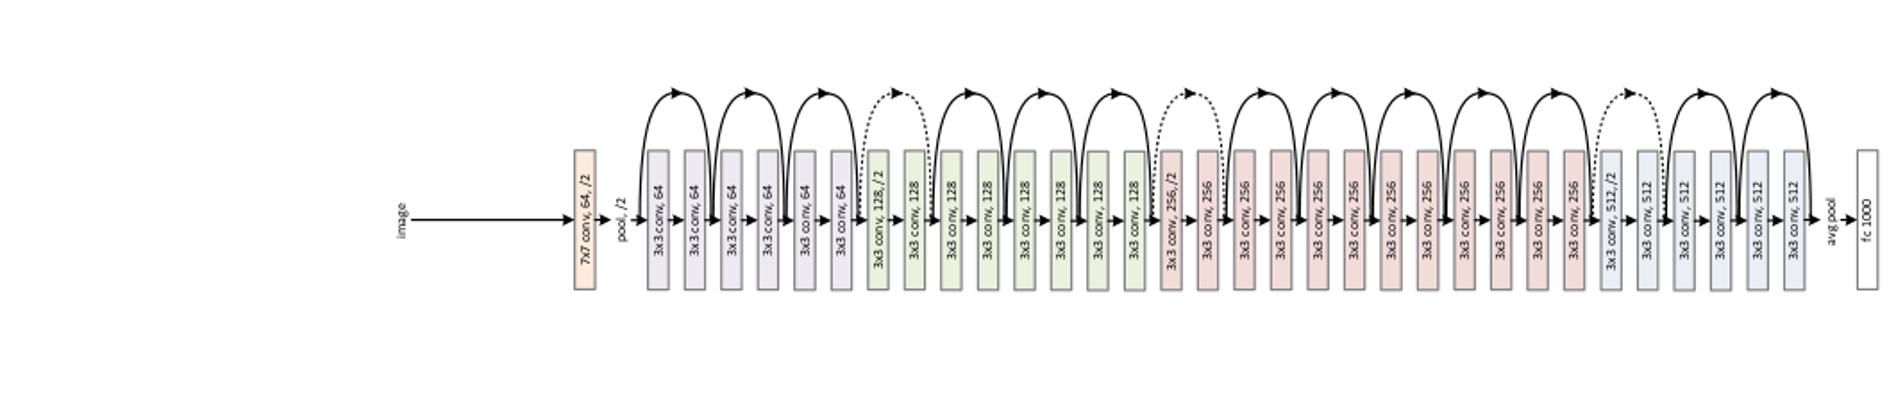

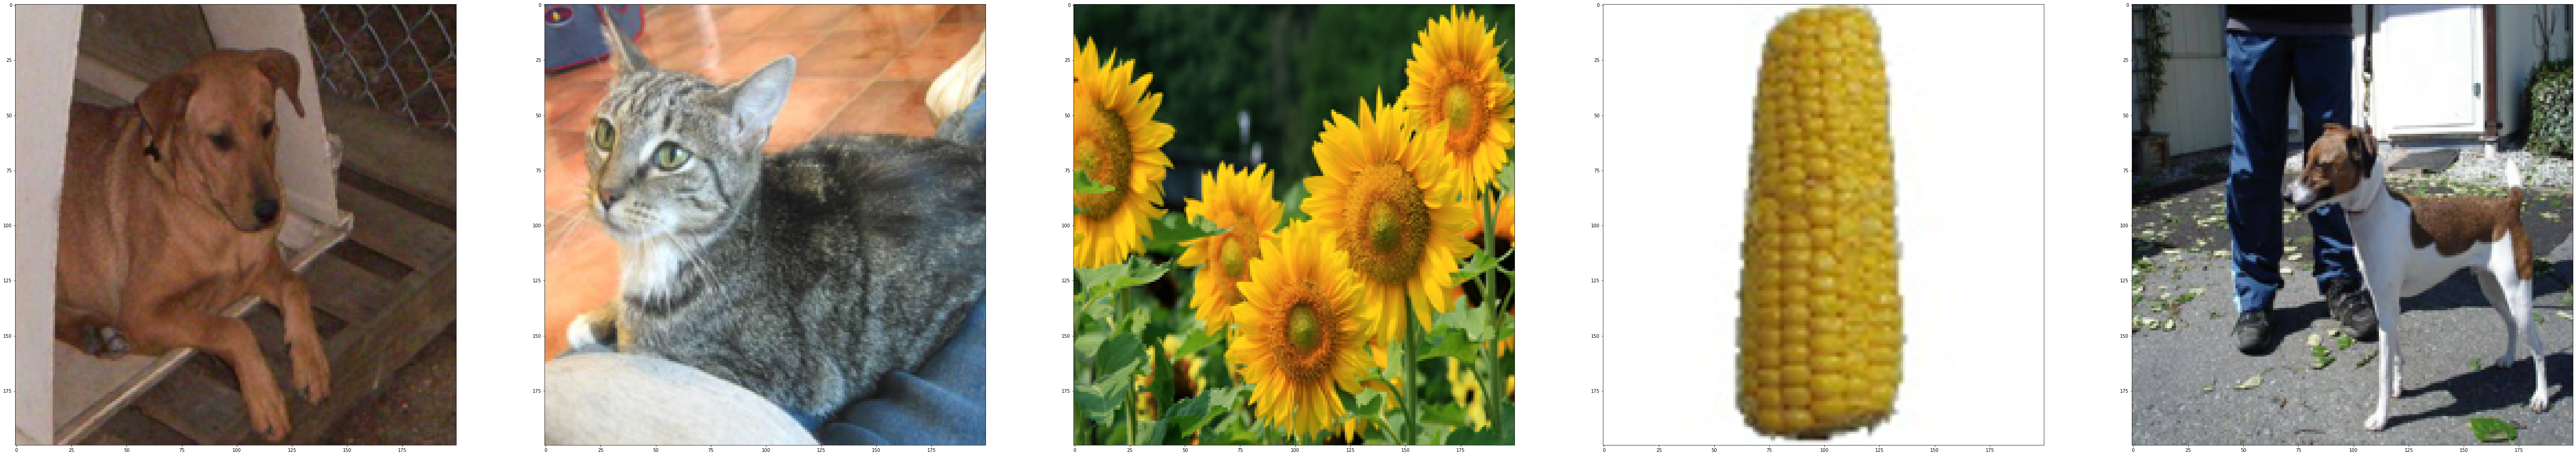

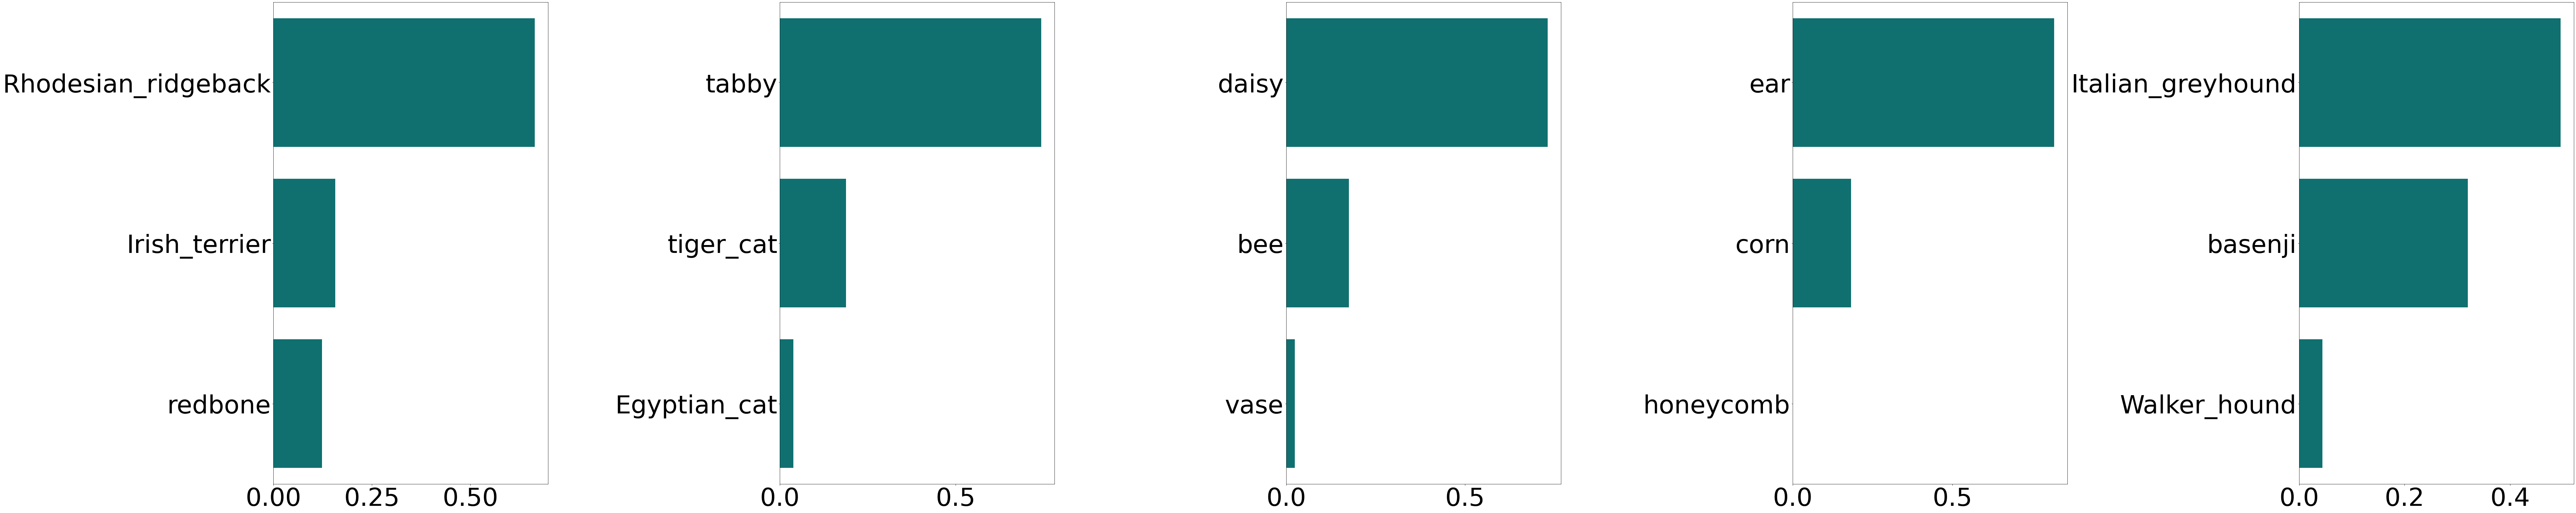

In [10]:
from keras.applications import ResNet50
resnet50_weights = "../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5"
resnet50_model = ResNet50(weights=resnet50_weights)
get_predictions(resnet50_model)

It is interesting to note that the predictions of VGG-16 and ResNet50 are very close. In some cases the order of top 3 predictions is different but both models have predicted the same classes for top 3 predictions.

# 3.EfficientNetB5

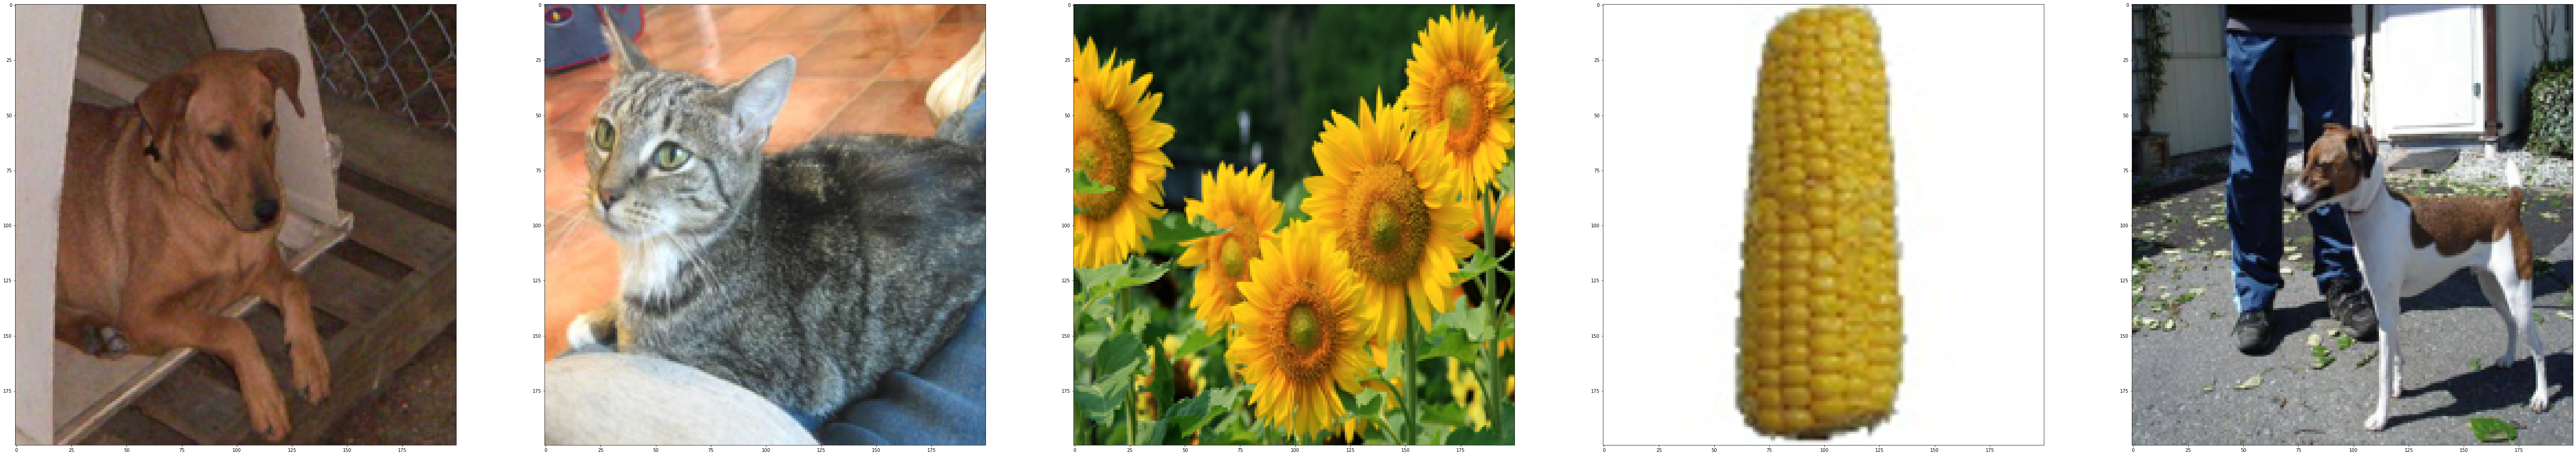

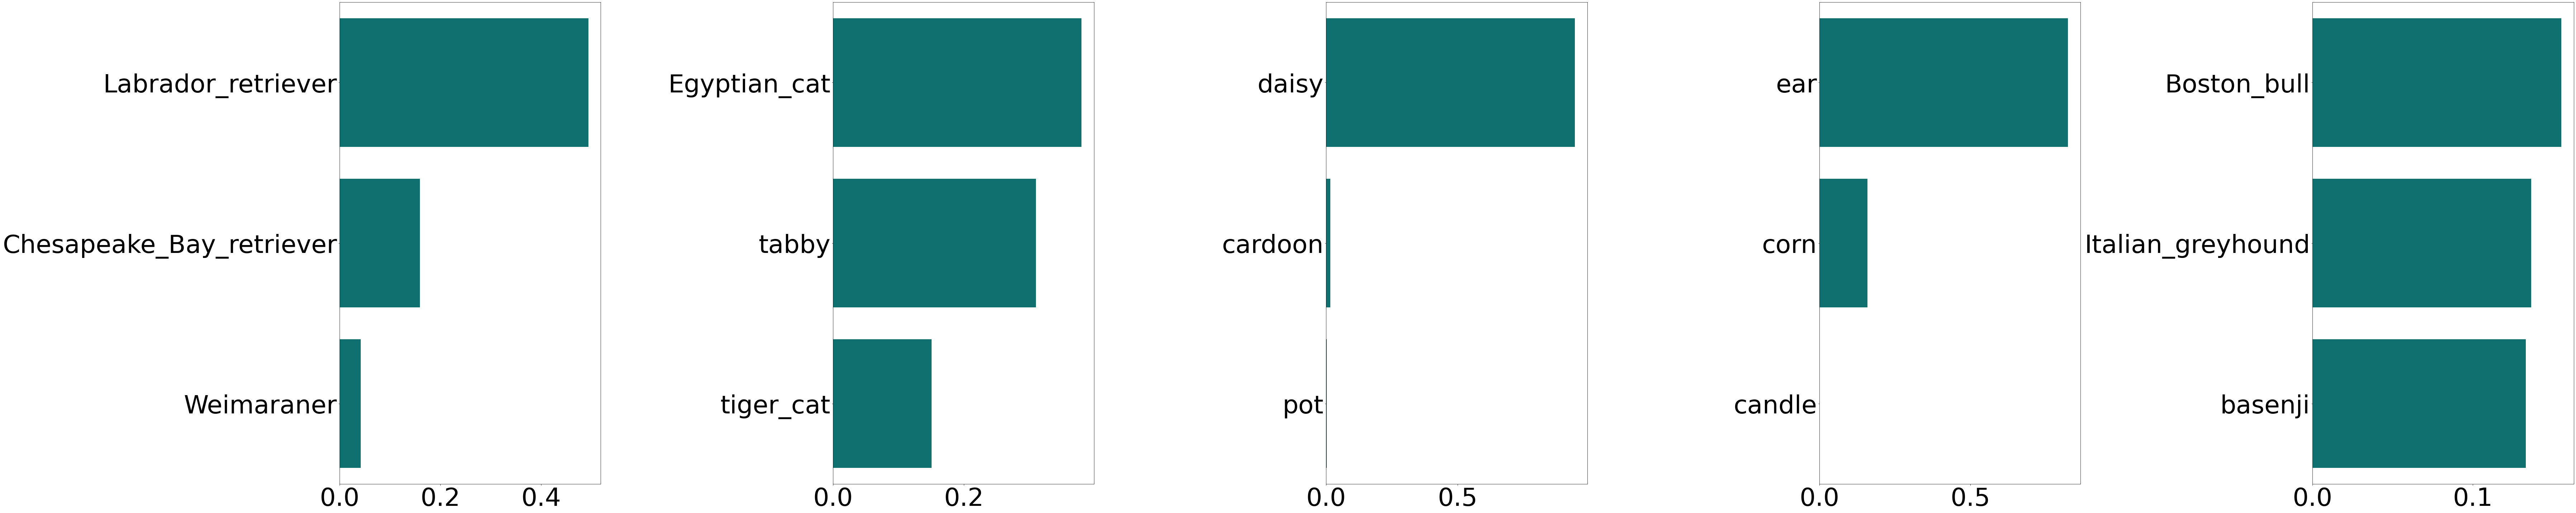

In [11]:
from tensorflow.keras.applications import EfficientNetB5
efficientnetb5_weights = "../input/efficientnetb5-weights/efficientnetb5.h5"
eb5_model = EfficientNetB5(weights = efficientnetb5_weights)
get_predictions(eb5_model)

EfficientNetB5 has done a decent job as all of its top 3 predicitons for each example are close to true class

This is however a very oversimplified use case meant to demonstrate how these algorithms predict a wide variety of objects. It is not really a reflection of their true predictive power

# Image Generator

Image generators are very helpful in this kind of problem as they are built to handle large amounts of data when only a relatively small amount of RAM is available. They will reduce memory usage and make code execute faster. Generators don’t store all results in memory, rather they generate them on the fly, hence the memory is only used when we ask for the result.

In this notebook all train and test images will be provided to the model by generators. The generator will supply a batch of 16 images at a time to the model for computing weights. This way we do not outrun the Notebook's RAM capacity of 13GB to hold the data of roughly 90K images .

I will create two image generators for both train and test sets.

In [12]:
# Set image height and width
# Many popular architectures use an input size of 224 X 224
img_height, img_width = 224, 224
num_tr_imgs = img_data['train_imgs'].sum()
num_te_imgs = img_data['test_imgs'].sum()
batch_size = 16
print(f'No of traiing examples: {num_tr_imgs} \nNo. of test examples: {num_te_imgs}')

No of traiing examples: 67692 
No. of test examples: 22688


In [13]:
train_gen = image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_gen = image.ImageDataGenerator(rescale=1./255)

"""
flow_from_directory is a generator method 
that takes path to a directory & 
generates batches of augmented data 

"""
tr_generator = train_gen.flow_from_directory(train_path, target_size=(img_height, img_width), 
                                             batch_size=batch_size, class_mode = 'categorical')

te_generator = test_gen.flow_from_directory(test_path, target_size=(img_height, img_width),
                                           batch_size=batch_size, class_mode='categorical')

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


# ResNet50

ResNet, short for Residual Networks is a classic neural network used as a backbone for many computer vision tasks. This model was the winner of ImageNet challenge in 2015. The fundamental breakthrough with ResNet was it allowed for training extremely deep neural networks with 150+layers successfully. Prior to ResNet training very deep neural networks was difficult due to the problem of vanishing gradients.

First I will use pretrained ResNet50 model and train only the top layer. I will not expect a good accuracy from this model for this task. This is only meant to demonstrate the difference in results between pretrained and retrained resnet models.

In [14]:
from keras.applications import ResNet50
base_model_resnet50 = ResNet50(weights ='imagenet', include_top = False)
x = base_model_resnet50.output
#Add a Global Average Pooling layer 
x = GlobalAveragePooling2D()(x)
#Add a DropOut layer for regularization
x = Dropout(0.3)(x)
#Add a dense layer
x = Dense(180, activation='relu')(x)
preds = Dense(131, activation='softmax')(x)

resnet50_model = Model(inputs=base_model_resnet50.input , outputs=preds)

#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

# train all layers of network
for layer in base_model_resnet50.layers:
    layer.trainable=False

resnet50_model.compile(optimizer=optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

with tf.device("/device:GPU:0"):
    resnet50_pretrained_hist = resnet50_model.fit_generator(tr_generator, epochs=3, shuffle=True, verbose=1, validation_data = te_generator)

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/3
4231/4231 [==============================] - 1032s 244ms/step - loss: 4.9421 - accuracy: 0.0105 - val_loss: 4.8648 - val_accuracy: 0.0093
Epoch 2/3
4231/4231 [==============================] - 943s 223ms/step - loss: 4.8851 - accuracy: 0.0113 - val_loss: 4.8571 - val_accuracy: 0.0154
Epoch 3/3
4231/4231 [==============================] - 947s 224ms/step - loss: 4.8726 - accuracy: 0.0117 - val_loss: 4.8527 - val_accuracy: 0.0141


**Display some test examples with true and predicted labels**

In [15]:
test_datagen = image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(unseen_data, target_size=(img_height, img_width), batch_size=1,
                                                 class_mode='categorical', shuffle=False)
fn = test_generator.filenames
nb_samples = len(fn)
            
data = load_files(unseen_data)
true_labels = data['target_names']
files = sorted(data['filenames'])

Found 20 images belonging to 20 classes.


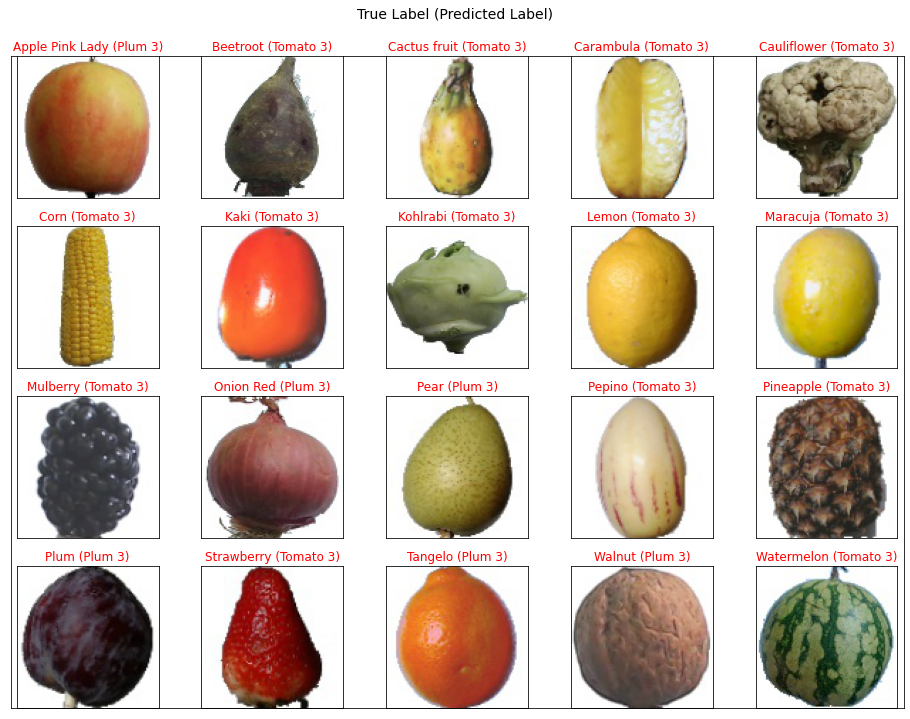

In [16]:
# Display some predictions

predicts = resnet50_model.predict_generator(test_generator,steps = nb_samples)

pred_idx = [np.argmax(predicts[i]) for i in range(20)]
pred_labels = []
for i in range(len(pred_idx)):
    for key in tr_generator.class_indices.keys():
        if tr_generator.class_indices[key] == pred_idx[i]:
            pred_labels.append(key)


fig = plt.figure(figsize=(16,12))
plt.title('True Label (Predicted Label) \n\n', fontsize=14)
plt.xticks([])
plt.yticks([])
for i in range(20):
    ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    ax.imshow(image.load_img(files[i]))  
    ax.set_title(f"{true_labels[i]} ({pred_labels[i]})", \
                 color=("green" if true_labels[i] == pred_labels[i] else "red"))
plt.show()

As expected, renset with pretrained weights and one trainable layer has done very poorly. Infact it hasn't learn anything at all. This can also be seen in the sample predictions where it got all predictions wrong, it predicted Grape Blue for all examples. This is because the model was trained on ImageNet database that has 1000 classes which include a wide range of objects. This model trained on a broad range of objects is almost fully constrained when we freeze all but the last layer and hence it fails to sufficiently learn on our all-fruits dataset. This explains why the model did a very good job predicting the classes in the earlier section of this notebook and a poor job now. One might think that the model would do much better with some additional layers and that is of course correct. However I'd stick to this architecture as later I will retrain the same resnet50 network by enabling all layers to learn and then we can see what difference that makes to the performance.  

# Retrain ResNet50

I will use the same architecture as that of pretrained resnet model to train all layers

In [17]:
from keras.applications import ResNet50
base_model_resnet50 = ResNet50(weights ='imagenet', include_top = False)
x = base_model_resnet50.output
#Add a Global Average Pooling layer 
x = GlobalAveragePooling2D()(x)
#Add a DropOut layer
x = Dropout(0.3)(x)
#Add a dense layer
x = Dense(180, activation='relu')(x)
preds = Dense(131, activation='softmax')(x)

resnet50_model2 = Model(inputs=base_model_resnet50.input , outputs=preds)

for layer in base_model_resnet50.layers:
    layer.trainable=True

resnet50_model2.compile(optimizer=optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

with tf.device("/device:GPU:0"):
    resnet50_retrained_hist = resnet50_model2.fit_generator(tr_generator, epochs=5, shuffle=True, verbose=1, validation_data = te_generator)

Epoch 1/5
4231/4231 [==============================] - 1092s 258ms/step - loss: 1.1086 - accuracy: 0.7898 - val_loss: 0.0596 - val_accuracy: 0.9846
Epoch 2/5
4231/4231 [==============================] - 1118s 264ms/step - loss: 0.0280 - accuracy: 0.9954 - val_loss: 0.0385 - val_accuracy: 0.9910
Epoch 3/5
4231/4231 [==============================] - 1074s 254ms/step - loss: 0.0102 - accuracy: 0.9980 - val_loss: 0.0212 - val_accuracy: 0.9947
Epoch 4/5
4231/4231 [==============================] - 1038s 245ms/step - loss: 0.0060 - accuracy: 0.9988 - val_loss: 0.0359 - val_accuracy: 0.9927
Epoch 5/5
4231/4231 [==============================] - 1070s 253ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 0.0412 - val_accuracy: 0.9929


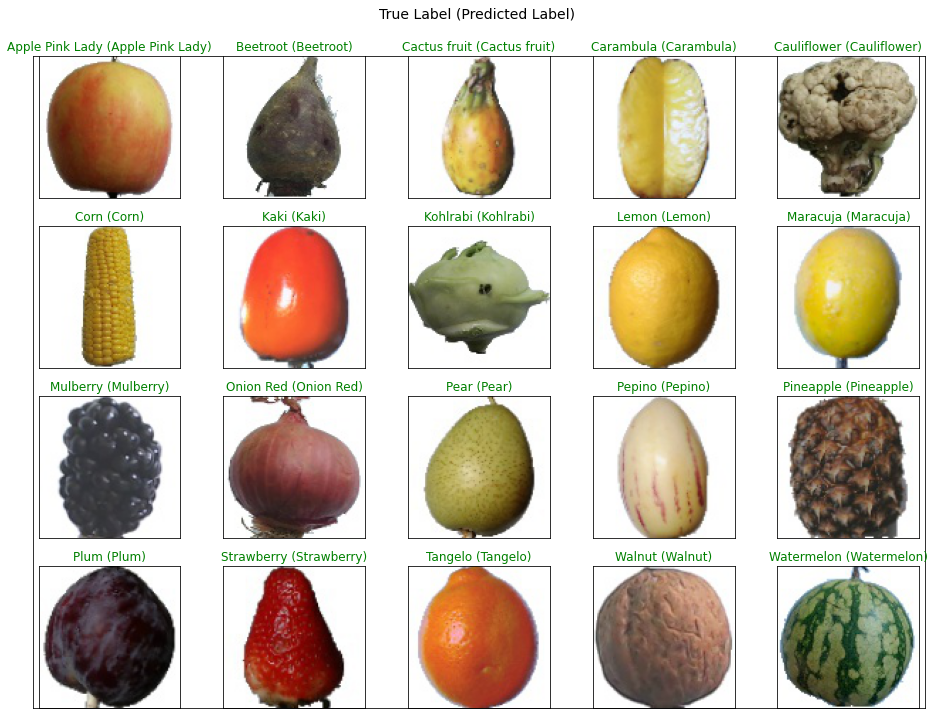

In [18]:
# Display some predictions

predicts3 = resnet50_model2.predict_generator(test_generator,steps = nb_samples)

pred_idx = [np.argmax(predicts3[i]) for i in range(20)]
pred_labels = []
for i in range(len(pred_idx)):
    for key in tr_generator.class_indices.keys():
        if tr_generator.class_indices[key] == pred_idx[i]:
            pred_labels.append(key)


fig = plt.figure(figsize=(16,12))
plt.title('True Label (Predicted Label) \n\n', fontsize=14)
plt.xticks([])
plt.yticks([])
for i in range(20):
    ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    ax.imshow(image.load_img(files[i]))  
    ax.set_title(f"{true_labels[i]} ({pred_labels[i]})", \
                 color=("green" if true_labels[i] == pred_labels[i] else "red"))
plt.show()

**Nice! The results are very impressive! We have finally been able to build a model that is predicting fruit classes with 99.4% accuracy!! ResNet has lived up to its reputation :D**

We have got tremendous improvement in performance by training all layers of ResNet over a pretrained network

# Results summary for Retrained ResNet50

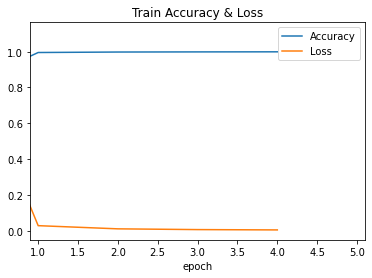

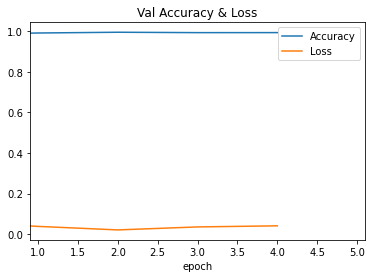

In [19]:
plt.plot(resnet50_retrained_hist.history['accuracy'])
plt.plot(resnet50_retrained_hist.history['loss'])
plt.title('Train Accuracy & Loss')
plt.xlabel('epoch')
plt.xlim([0.9, 5.1])
plt.legend(['Accuracy', 'Loss'], loc='best')
plt.show()

plt.plot(resnet50_retrained_hist.history['val_accuracy'])
plt.plot(resnet50_retrained_hist.history['val_loss'])
plt.title('Val Accuracy & Loss')
plt.xlabel('epoch')
plt.xlim([0.9, 5.1])
plt.legend(['Accuracy', 'Loss'], loc='best')
plt.show()

# Conclusion

In this notebook, 
* We have seen how we can use pretrained models for prediction
* Retrained ResNet50 has shown high accuracy after seeing just a few hundred images of each class and in 5 epochs
* Through this exercise, we got an opportunity to witness the robustness of ResNet architecture for image classification problems